# **TAREA CNN (Chess Data Set)**

Aarón Medina Melián

En esta tarea entrenaremos una red convolucional con el objetivo de que clasifique adecuadamente las imágenes de las piezas del ajedrez. El dataset lo obtendremos de Kaggle, realizaremos data augmentetion para tener un dataset más amplio y definiremos el modelo.

https://www.kaggle.com/datasets/niteshfre/chessman-image-dataset?resource=download

# Importación e instalación de las librerías necesarias

In [1]:
!pip install split-folders

In [2]:
!pip install -q kaggle

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from PIL import Image, ImageOps, ImageDraw
import keras
from keras import layers
import matplotlib.pyplot as plt
from google.colab import files
import cv2
import glob
import splitfolders
import secrets
import string
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator
import random

from keras import regularizers, initializers

#Importación del dataset desde Kaggle

##Conectar con la API

En este post de Kaggle he encontrado la manera de poder obtener las imágenes del dataset a partir de la API de Kaggle, generando un Token que he guardado en mi Github para luego añadirlo y poder obtener las imágenes con mayor comodidad.

https://www.kaggle.com/discussions/general/74235

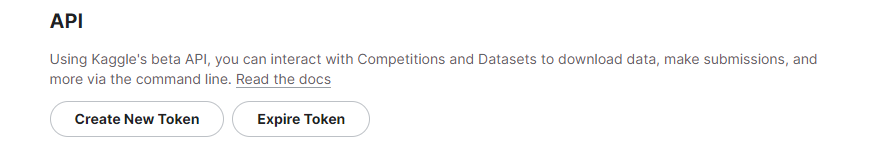

In [4]:
!wget 'https://raw.githubusercontent.com/aaronmed/7ro/master/kaggle.json'

--2024-03-17 10:56:35--  https://raw.githubusercontent.com/aaronmed/7ro/master/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66 [text/plain]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      66  --.-KB/s    in 0s      

2024-03-17 10:56:35 (2.63 MB/s) - ‘kaggle.json’ saved [66/66]



In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                           title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
syedanwarafridi/vehicle-sales-data                            Vehicle Sales Data                                  19MB  2024-02-21 20:16:17          14520        264  1.0              
sudarshan24byte/online-food-dataset                           Online Food Dataset                                  3KB  2024-03-02 18:50:30           4383         75  0.9411765        
arnavvvvv/spotify-music                                       Top Spotify Songs                                   47KB  2024-03-06 05:20:29           4037         59  1.0              
tarunrm09/climate-change-indicators                           Climate chang

## Descargar el dataset desde Kaggle

In [6]:
! kaggle datasets download -d 'niteshfre/chessman-image-dataset'

 87% 50.0M/57.6M [00:00<00:00, 84.9MB/s]
100% 57.6M/57.6M [00:00<00:00, 81.8MB/s]


In [7]:
! unzip '/content/chessman-image-dataset.zip'

Archive:  /content/chessman-image-dataset.zip
  inflating: Chessman-image-dataset/Chess/Bishop/00000000.JPG  
  inflating: Chessman-image-dataset/Chess/Bishop/00000001.jpg  
  inflating: Chessman-image-dataset/Chess/Bishop/00000002.JPG  
  inflating: Chessman-image-dataset/Chess/Bishop/00000003.png  
  inflating: Chessman-image-dataset/Chess/Bishop/00000004.jpg  
  inflating: Chessman-image-dataset/Chess/Bishop/00000006.jpg  
  inflating: Chessman-image-dataset/Chess/Bishop/00000007.jpg  
  inflating: Chessman-image-dataset/Chess/Bishop/00000008.jpg  
  inflating: Chessman-image-dataset/Chess/Bishop/00000009.png  
  inflating: Chessman-image-dataset/Chess/Bishop/00000010.jpg  
  inflating: Chessman-image-dataset/Chess/Bishop/00000011.jpg  
  inflating: Chessman-image-dataset/Chess/Bishop/00000012.jpg  
  inflating: Chessman-image-dataset/Chess/Bishop/00000013.jpg  
  inflating: Chessman-image-dataset/Chess/Bishop/00000015.png  
  inflating: Chessman-image-dataset/Chess/Bishop/00000016.

#Tratamiento de las imágenes, separación en test, train, val

Una función utilizando ImageDraw para generar líneas aleatorias en las imágenes para el data_augmentetion

In [8]:
def dibuja_cosas_aleatorias_imagen(image):

  imagen_modificada = image.copy()

  # Crea un objeto ImageDraw para dibujar en la imagen
  draw = ImageDraw.Draw(imagen_modificada)

  # Tamaño de la imagen existente
  width, height = imagen_modificada.size

  # Número de líneas y formas geométricas aleatorias que quieres añadir
  num_shapes = 50

  # Añade líneas y formas aleatorias
  for _ in range(num_shapes):
      x1 = random.randint(50, width)
      y1 = random.randint(0, height)
      x2 = random.randint(0, width)
      y2 = random.randint(25, height)

      # Escoge un color aleatorio en formato RGB
      color = (random.randint(0, 385), random.randint(0, 235), random.randint(0, 155))

      draw.line([(x1, y1), (x2, y2)], fill=color, width=7)
  return imagen_modificada

Este código fue usado mediante el desempeño de la tarea para probar los diferentes métodos que nos proporciona la librería ImageOps y ver las diferencias que se generaban entre la imagen origina y la imagen modificada.

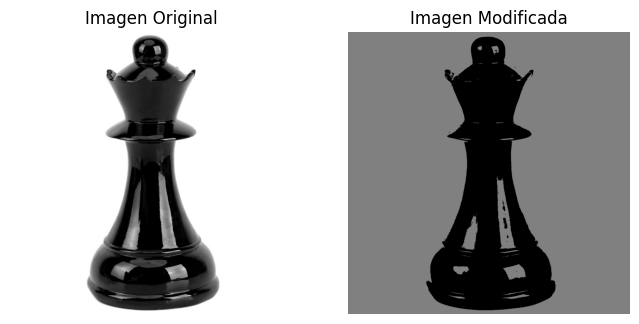

In [9]:
imagen = Image.open("/content/Chessman-image-dataset/Chess/Queen/00000001.jpg")

#imagen_modificada = ImageOps.expand(imagen, border=150, fill='red')

imagen_modificada = ImageOps.posterize(imagen, 1)

# Crear la figura y los subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 8))

# Mostrar la imagen original a la izquierda
axes[0].imshow(imagen)
axes[0].axis('off')
axes[0].set_title('Imagen Original')

# Mostrar la imagen modificada a la derecha
axes[1].imshow(imagen_modificada)
axes[1].axis('off')
axes[1].set_title('Imagen Modificada')

plt.show()

Hacemos split de las imágenes para separarlas en test, train y val

In [10]:
input_folder = "/content/Chessman-image-dataset/Chess"

splitfolders.ratio(input_folder, output="Chess-splitted", seed=42, ratio=(0.6, 0.2, 0.2))

Copying files: 556 files [00:00, 3227.84 files/s]


Generamos una función que nos ayudará a la hora de nombrar las nuevas imágenes creadas

In [11]:
def generar_nombre_aleatorio():
    caracteres = string.ascii_letters + string.digits
    codigo_aleatorio = ''.join(secrets.choice(caracteres) for _ in range(10))
    return codigo_aleatorio

Generamos una función que nos hará de data augmentetion, recibirá una imagen como párametro y de maneara aleatoria le aplicará uno de los filtros contenidos en el array de transforamtions

In [12]:
def random_augmentation(image):
    # Lista de posibles transformaciones
    transformations = [
        lambda img: ImageOps.crop(img, border=50), # Recortar imagen
        lambda img: img.rotate(30), # Deformar la imagen rotándola 30 grados
        lambda img: img.rotate(90), # Deformar la imagen rotándola 90 grados
        lambda img: img.rotate(120), # Deformar la imagen rotándola 120 grados
        lambda img: ImageOps.equalize(img), # Ecualizar histograma
        lambda img: ImageOps.expand(img, border=20, fill='white'), # Expandir imagen
        lambda img: ImageOps.expand(img, border=50, fill='white'), # Expandir imagen
        ImageOps.flip, # Voltear horizontalmente o verticalmente
        lambda img: ImageOps.grayscale(img), # Convertir a escala de grises
        lambda img: ImageOps.invert(img), # Invertir colores
        ImageOps.mirror, # Espejo horizontal
        lambda img: ImageOps.posterize(img, 1), # Posterizar la imagen a 1 nivel
        lambda img: ImageOps.solarize(img)  # Solarizar la imagen
    ]

    # Selecciona una primera transformación aleatoria de la lista
    transformation = np.random.choice(transformations)

    # Selecciona una segunda transformación aleatoria de la lista
    second_transformation = np.random.choice(transformations)


    # Aplica la primera transformación a la imagen
    augmented_image = transformation(image)

    # Aplica la segunda transformación a la imagen
    augmented_image = second_transformation(image)

    return augmented_image

Generamos una función que nos generá las imágenes del data augmentetion recibiendo la carpeta y las veces que se repetirá el bucle

In [13]:
def genera_imagenes_iteraciones(carpeta_actual, repeticiones):
  nuevas_imagenes = 0
  for i in range(repeticiones):
    # Recorrer todas las subcarpetas y archivos dentro de la carpeta actual
    for directorio_raiz, directorios, archivos in os.walk(carpeta_actual):
        # Iterar sobre cada archivo en el directorio actual
        for archivo in archivos:
            # Verificar si el archivo es una imagen (puedes ampliar esta lógica según los tipos de imagen que esperas)
            if archivo.endswith(".jpg") or archivo.endswith(".png") or archivo.endswith(".JPG") or archivo.endswith(".jpeg"):
                # Abrir la imagen
                ruta_archivo = os.path.join(directorio_raiz, archivo)

                # Usamos este if para solamente hacer modificaciones de las imágenes originales y no de las que previamente han sido modificadas
                if "augmented-" not in archivo:

                  imagen = Image.open(ruta_archivo)

                  # Código utilizado para ver la imagen antes de la modificación
                  # plt.imshow(imagen)
                  # plt.axis('off')  # Desactivar ejes
                  # plt.show()

                  imagen_modificada = random_augmentation(imagen)

                  # Código utilizado para ver la imagen después de la modificación
                  # plt.imshow(imagen_modificada)
                  # plt.axis('off')  # Desactivar ejes
                  # plt.show()

                  # Guardar la nueva imagen en la misma carpeta con el nuevo nombre
                  archivo = archivo.split('-', 1)
                  archivo = archivo[1] if len(archivo) > 1 else archivo[0]
                  nombre_nueva_imagen = "augmented-" + generar_nombre_aleatorio() + "-" + archivo

                  ruta_destino = os.path.join(directorio_raiz, nombre_nueva_imagen)
                  imagen_modificada.save(ruta_destino)

                  # Cerrar la imagen original
                  imagen.close()
                  nuevas_imagenes = nuevas_imagenes + 1

  print("------------------------------------------")
  print("------------------------------------------")
  print("PROCESO COMPLETADO.")
  print("SE HAN GENERADO", nuevas_imagenes, "NUEVAS IMÁGENES")
  print("------------------------------------------")
  print("------------------------------------------")

Generamos nuevas imágenes. Realizaremos una segunda llamada a la función para generar más imágenes solamente de la reina ya que es de las peores que precisión suele tener debido a su parecido con las otras fichas como veremos luego en la matriz de confusión en el final de este notebook



In [14]:
genera_imagenes_iteraciones("/content/Chess-splitted/train", 10)
genera_imagenes_iteraciones("/content/Chess-splitted/train/Queen", 15)

------------------------------------------
------------------------------------------
PROCESO COMPLETADO.
SE HAN GENERADO 3280 NUEVAS IMÁGENES
------------------------------------------
------------------------------------------
------------------------------------------
------------------------------------------
PROCESO COMPLETADO.
SE HAN GENERADO 675 NUEVAS IMÁGENES
------------------------------------------
------------------------------------------


Esta variable contiene un mapeo de número de clase a ficha

In [15]:
MAP_CHARACTERS = {
    0: 'Bishop', 1: 'King', 2: 'Knight',
    3: 'Pawn', 4: 'Queen', 5: 'Rook',
}

Creamos una función para contar las extensiones que tienen cada uno de los archivos con el objetivo de descartar las que no nos interesen que entren en nuestros datos

In [16]:
def contar_extensiones(carpeta):

    contador_extensiones = Counter()

    # Iteramos sobre todos los archivos en la carpeta
    for ruta, _, archivos in os.walk(carpeta):
        for archivo in archivos:
            # Obtenemos la extensión del archivo
            _, extension = os.path.splitext(archivo)
            # Añadimos la extensión al contador
            contador_extensiones[extension] += 1

    return contador_extensiones

carpeta = input_folder
resultados = contar_extensiones(carpeta)

# Mostramos los resultados
for extension, cantidad in resultados.items():
    print(f"Extensión: {extension}, Cantidad: {cantidad}")

Extensión: .jpg, Cantidad: 465
Extensión: .jpeg, Cantidad: 7
Extensión: .png, Cantidad: 69
Extensión: .JPG, Cantidad: 10
Extensión: .php, Cantidad: 1
Extensión: .fcgi, Cantidad: 2
Extensión: .webp, Cantidad: 1
Extensión: .gif, Cantidad: 1


Esta función carga los datos de training en imágenes. Como las imágenes tienen tamaños distintas, utilizamos la librería opencv para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.


In [17]:
IMG_SIZE = 64

In [18]:
def load_train_set(dirname, map_characters, verbose=True):
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg") or file.endswith("png") or file.endswith("jpeg") or file.endswith("JPG") or file.endswith("webp")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

Esta función funciona de manera equivalente a la función load_train_set pero cargando los datos de test.

In [19]:
def load_test_set(dirname, map_characters, verbose=True):
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg") or file.endswith("png") or file.endswith("jpeg") or file.endswith("JPG") or file.endswith("webp")]
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_test.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_test.append(label)
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)

Cargamos los datos

In [20]:
DATASET_TRAIN_PATH_COLAB = '/content/Chess-splitted/train'
DATASET_TEST_PATH_COLAB = '/content/Chess-splitted/test'

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 572 imágenes encontradas de Bishop
Leyendo 484 imágenes encontradas de King
Leyendo 693 imágenes encontradas de Knight
Leyendo 693 imágenes encontradas de Pawn
Leyendo 1170 imágenes encontradas de Queen
Leyendo 671 imágenes encontradas de Rook
Leídas 116 imágenes de test


Reorganiza aleatoriamente los datos de entrada X y sus etiquetas correspondientes y

In [21]:
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

# Normalización de las imágenes

In [22]:
X = X / 255.0
X_t = X_t / 255.0

# Análisis de los datos a utilizar

In [23]:
def visualize_example(x):
  plt.figure()
  plt.imshow(x)
  plt.colorbar()
  plt.grid(False)
  plt.show()

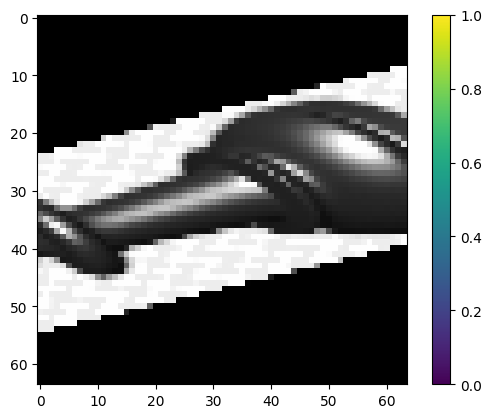

Pawn
(64, 64, 3)


In [24]:
visualize_example(X[70]) # Visualiza la imagen normalizada con valores de 0 a 1
print(MAP_CHARACTERS[y[70]]) # Acceso al diccionario
print(X[70].shape[0:3]) # Dimensiones de la imagen tras resize con los 3 canales RGB

#Creación del modelo

In [25]:
#batch_size=128
num_classes=6
epochs=5
img_rows,img_cols=IMG_SIZE,IMG_SIZE
input_shape=(img_rows,img_cols,3) #(64,64,3)

In [26]:
# convert class vectors to binary class matrices
y = keras.utils.to_categorical(y, num_classes)
y_t = keras.utils.to_categorical(y_t, num_classes)

 Este modelo se compone de varias capas:

- Capas convolucionales: Se aplican convoluciones sobre la entrada para extraer características.
- Capas de agrupación máxima: Reducen la dimensionalidad de las características extraídas.
- Capas densas: Realizan la clasificación final.

El modelo también incluye regularización L1 y L2 en una de las capas densas y una capa de dropout para evitar el sobreajuste.

In [27]:
model = keras.Sequential([
  keras.layers.Conv2D(32, kernel_size=(3, 3), data_format="channels_last",input_shape=(64, 64, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(500, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=0.001, l2=0.001)),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(6, activation='softmax')
])


In [28]:
model.summary()
model.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 512)       590336    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 512)         0

#Entrenamiento

In [29]:
history = model.fit(X, y, epochs=20, validation_split = 0.2)

Epoch 1/20
108/108 [==============================] - 74s 651ms/step - loss: 7.8464 - accuracy: 0.2668 - val_loss: 2.1188 - val_accuracy: 0.2777
Epoch 2/20
108/108 [==============================] - 69s 641ms/step - loss: 2.0670 - accuracy: 0.2720 - val_loss: 2.0709 - val_accuracy: 0.2777
Epoch 3/20
108/108 [==============================] - 70s 648ms/step - loss: 2.0585 - accuracy: 0.2776 - val_loss: 2.0228 - val_accuracy: 0.3197
Epoch 4/20
108/108 [==============================] - 68s 629ms/step - loss: 2.0022 - accuracy: 0.3100 - val_loss: 1.9993 - val_accuracy: 0.3279
Epoch 5/20
108/108 [==============================] - 68s 630ms/step - loss: 1.9721 - accuracy: 0.3295 - val_loss: 1.9338 - val_accuracy: 0.3629
Epoch 6/20
108/108 [==============================] - 69s 640ms/step - loss: 1.9575 - accuracy: 0.3573 - val_loss: 1.9612 - val_accuracy: 0.3571
Epoch 7/20
108/108 [==============================] - 68s 631ms/step - loss: 1.9208 - accuracy: 0.4031 - val_loss: 1.9216 - val_ac

In [30]:
def plot_acc(history, title="Model Accuracy"):
  """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

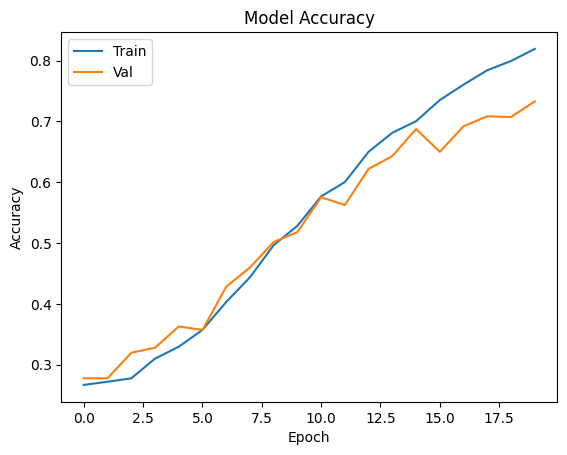

In [31]:
plot_acc(history)

In [32]:
def plot_loss(history, title="Model Loss"):
  """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

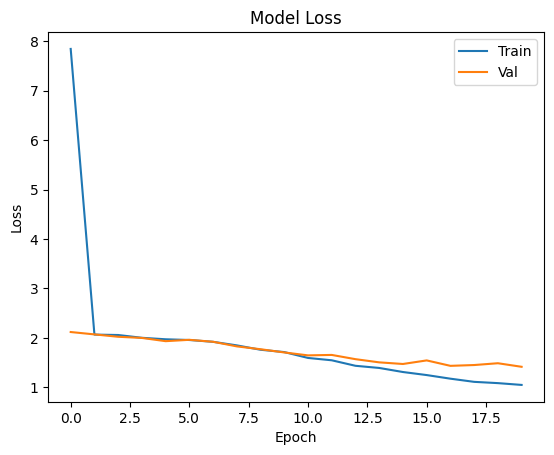

In [33]:
plot_loss(history)

Evaluamos el rendimiento

In [34]:
model.evaluate(X_t, y_t, batch_size=32, verbose=1)

4/4 [==============================] - 1s 131ms/step - loss: 2.3486 - accuracy: 0.4397


[2.3485851287841797, 0.4396551847457886]

Hacemos una predicción

In [35]:
prediccion = model.predict(X_t, batch_size=32, verbose=1)

4/4 [==============================] - 1s 125ms/step


Vemos los resultados de la predicción

In [36]:
print(prediccion)
prediccion.shape

[[8.99353325e-01 9.14279372e-02 2.63549628e-05 9.06607136e-03
  1.25988168e-04 1.93177570e-07]
 [8.23763832e-02 3.19691535e-05 1.67079115e-08 9.17154133e-01
  4.25267499e-04 1.22685415e-05]
 [9.84155536e-01 1.68390732e-04 3.69349837e-05 1.27581768e-02
  2.87655578e-03 4.29676538e-06]
 [7.52120793e-01 2.75429076e-04 4.11032845e-04 2.44738728e-01
  2.32243212e-03 1.31497713e-04]
 [8.60871911e-01 1.32260367e-01 8.17603996e-06 2.98087602e-03
  3.87702067e-03 1.53337953e-06]
 [5.42830110e-01 1.79356504e-02 1.10716312e-04 3.57887782e-02
  3.99493277e-01 3.84146534e-03]
 [3.72728795e-01 5.01494944e-01 1.43162999e-03 2.31084768e-02
  9.95392650e-02 1.69687602e-03]
 [9.71444309e-01 1.91691220e-02 9.67569667e-06 8.08294024e-03
  1.29289553e-03 9.18586807e-07]
 [9.76264894e-01 1.97026040e-03 1.45359794e-02 6.74569979e-03
  2.30451682e-04 2.52673577e-04]
 [9.09677939e-04 8.15505791e-06 1.10324094e-04 7.30902195e-01
  6.65191934e-03 2.61417717e-01]
 [2.75276750e-01 2.48644711e-03 1.76215649e-03 6.9

(116, 6)

Generamos un informe de clasificación que resume las métricas de rendimiento del modelo

In [37]:
LIST_FIGURES = ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']
informe = classification_report(np.argmax(y_t,axis=1), np.argmax(prediccion,axis=1), target_names=LIST_FIGURES)
print(informe)

              precision    recall  f1-score   support

      Bishop       0.36      0.56      0.43        18
        King       0.56      0.31      0.40        16
      Knight       0.70      0.64      0.67        22
        Pawn       0.35      0.32      0.33        22
       Queen       0.37      0.41      0.39        17
        Rook       0.40      0.38      0.39        21

    accuracy                           0.44       116
   macro avg       0.46      0.44      0.44       116
weighted avg       0.46      0.44      0.44       116



Mostramos la matriz de confusión mencionada anteriormente

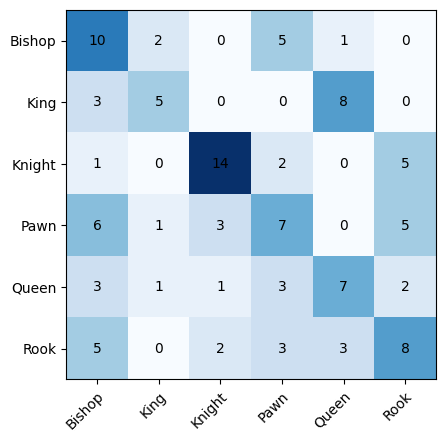

In [38]:
# Calcular la matriz de confusión para clasificación multi-label
matriz_confusion = confusion_matrix(np.argmax(y_t,axis=1), np.argmax(prediccion,axis=1))

# Crear una figura y ejes
fig, ax = plt.subplots()
im = ax.imshow(matriz_confusion, cmap='Blues')

# Mostrar las etiquetas en los ejes
ax.set_xticks(np.arange(len(LIST_FIGURES)))
ax.set_yticks(np.arange(len(LIST_FIGURES)))
ax.set_xticklabels(LIST_FIGURES)
ax.set_yticklabels(LIST_FIGURES)

# Rotar las etiquetas y ajustar la posición
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Mostrar los valores en cada celda
for i in range(len(LIST_FIGURES)):
    for j in range(len(LIST_FIGURES)):
        text = ax.text(j, i, matriz_confusion[i, j], ha="center", va="center", color="black")

plt.show()

# Conversión del notebook a PDF para su entrega

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
pandoc set to manually installed.
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6
  libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet ruby-rubygems
  ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils teckit tex-common tex-gyre
  texlive-base texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/CURSO IA/7RO/TAREAS/TAREA 6 CNN (Chess Data Set)/7RO_TAREA_6_23-24_CNN_ChessDataSet_AaronMedinaMelian.ipynb" ./

cp: cannot stat '/content/drive/MyDrive/CURSO IA/7RO/TAREAS/TAREA 6 CNN (Chess Data Set)/TAREA_CNN.ipynb': No such file or directory


In [ ]:
!jupyter nbconvert --to PDF "TAREA 6 (23-24) CNN Chess Data Set.ipynb"

[NbConvertApp] WARNING | pattern 'TAREA_CNN.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    E